In [2]:
# O zoo fornece recurso para series temporais
library(zoo)

# dataframe de alto desempenho do R
library(data.table)

# forçar o fundo branco
library(ggplot2)


Anexando pacote: 'zoo'


Os seguintes objetos são mascarados por 'package:base':

    as.Date, as.Date.numeric



Anexando pacote: 'data.table'


Os seguintes objetos são mascarados por 'package:zoo':

    yearmon, yearqtr




#### Limpeza dos dados

* dados ausentes
* upsamping e dowsampling
* suavização dos dados
* lidar com sazonalidade dos dados
* prevenir lookaheads não intencionais

Dados ausente em series temporais são bem comuns pois a carga longitudinal é bastante pesada, para lidar com isso se tem alguns metodos:
1. `Imputing`
2. `interpolação`: usa pontos vizinhos para lidar com valores ausentes
3. `Exclusão de dados`

In [3]:

path_ = "C:\\Users\\mateu\\Documents\\MEGA\\Projetos-git\\analise-pratica-series-temporais_predicao-stats-ml\\capitulo-2-encontrando-dados-e-usando-data-wrangling-com-st\\dataset\\gov\\UNRATE.csv"
# Lendo arquivo 
unemp = fread(input = path_ )

In [4]:
head(unemp, n=5)

DATE,UNRATE
<IDate>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [5]:
# convertendo para tipo data
unemp[, DATE:=as.Date(DATE)]

setkey(unemp, DATE)

In [6]:
head(x=unemp, n=5)

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


In [7]:
## Gera um conj. de dados onde os dados estão aleatoriamente
### ausentes
rand.unemp.idx = sample(
    1:nrow(unemp), .1*nrow(unemp)
)
rand.unemp.idx

[1] 337 315 738 713 623 221 552 381 815 180 276 569 429 198 150 739 559 400  48
[20] 794 397 512 460 647 113 462  46 522 485 541 511 346  94 747  80 615 342 390
[39] 787 483 834 565 258 237 457 439 175 152 353  85 827 567 433 444  29  51 361
[58]  87 612 553 686 232 736 211 473 506 651 687 537 629 463 493 311 451   5 247
[77]  16 544 440 781 803 585 380 795

In [8]:
rand.unemp = unemp[-rand.unemp.idx]
head(rand.unemp, n=10)

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-06-01,3.6
1948-07-01,3.6
1948-08-01,3.9
1948-09-01,3.8
1948-10-01,3.7


In [9]:
## Gera um conj. de dados onde os dados possuem maior
### probalidade de ausencia quando o desemprego é alto

alto.unemp.idx = which(unemp$UNRATE>8)
num.to.select  = .2*length(alto.unemp.idx)

alto.unemp.idx = sample(alto.unemp.idx, )

bias.unemp = unemp[-alto.unemp.idx]

In [10]:
which(bias.unemp$UNRATE>8)

integer(0)

Usando rolling join para ler valores ausentes

In [11]:
all.dates = seq(from = unemp$DATE[1], to = tail(unemp$DATE, 1), by='months')

In [12]:
rand.unemp = rand.unemp[J(all.dates), on='DATE', roll=0]
bias.unemp = rand.unemp[J(all.dates), on='DATE', roll=0]

In [13]:
rand.unemp[, rpt := is.na(UNRATE)]

In [14]:
head(rand.unemp[rand.unemp$rpt==TRUE], 2)

DATE,UNRATE,rpt
<date>,<dbl>,<lgl>
1948-05-01,NA,TRUE
1949-04-01,NA,TRUE


#### Trando dados ausentes
**forward fill**: preenche valores ausente com base no valor anterior a ele que não é ausente

In [40]:
a = c(NA, 12, NA, 34, 30, NA, 32, NA)

na.locf(a, na.rm=TRUE)

[1] 12 12 34 30 30 32 32

In [16]:
# Forward fill
rand.unemp[, impute.ff := na.locf(UNRATE, na.rm = FALSE)]
bias.unemp[, impute.ff := na.locf(UNRATE, na.rm = FALSE)]

NULL

NULL

NULL

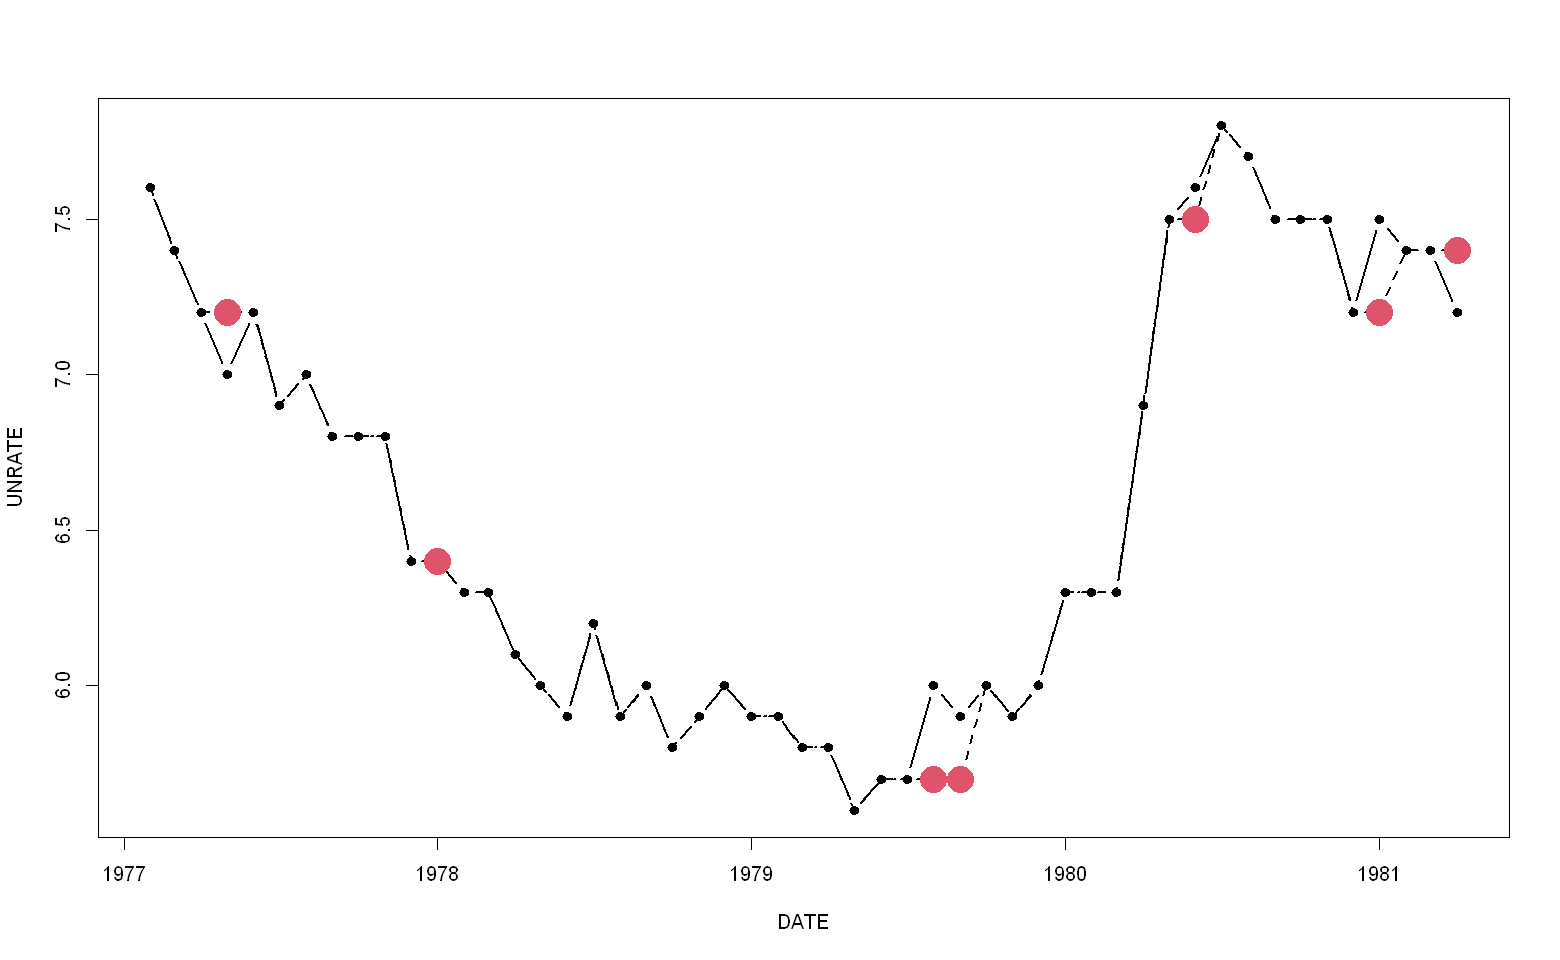

In [17]:
par(bg='white')
options(repr.plot.width = 13, repr.plot.height = 8)
unemp[350:400, plot(
    DATE, UNRATE, col=1, lwd=2, type='b', pch=19
)]
rand.unemp[
    350:400, lines(
    DATE, impute.ff, col=1, lwd=2, lty=2
)
]
rand.unemp[350:400][rpt==TRUE, 
    points(DATE, impute.ff, col=2, pch=19, cex=3)
]

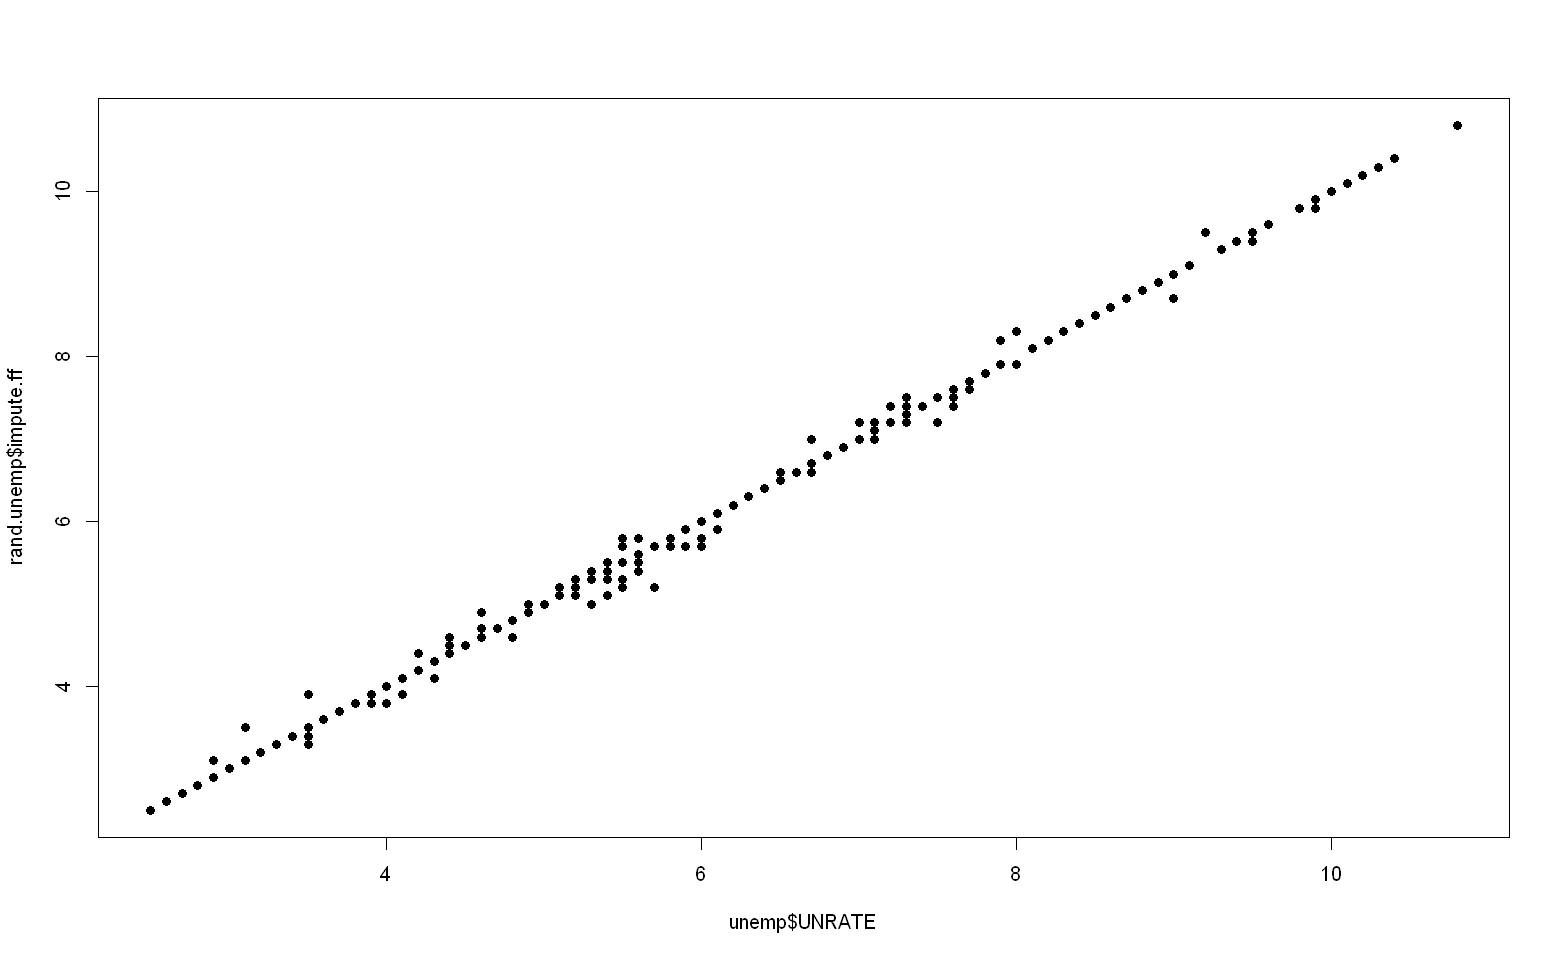

In [18]:
par(bg = 'white')
plot(unemp$UNRATE, rand.unemp$impute.ff, pch=19)

**Média movel :** Semelhante ao forward fill mas usa a media e mediana para imputar valores ausentes

In [42]:
rollapply(c(NA, NA, a), 3,
    function(x){
        if(!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    })
a

[1] NaN  12  12  34  30  32  32  32

[1] NA 12 NA 34 30 NA 32 NA

In [43]:
64/2

[1] 32

In [19]:
rand.unemp[,
    impute.rm.naolookahead := rollapply(c(NA, NA, UNRATE) ,3 ,
    function(x){
        if(!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    })
]

In [20]:
head(rand.unemp, n=2)

DATE,UNRATE,rpt,impute.ff,impute.rm.naolookahead
<date>,<dbl>,<lgl>,<dbl>,<dbl>
1948-01-01,3.4,FALSE,3.4,3.4
1948-02-01,3.8,FALSE,3.8,3.8


In [21]:
bias.unemp[,
    impute.rm.naolookahead := rollapply(c(NA, NA, UNRATE) ,3 ,
    function(x){
        if(!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    })
]

fazem a imputacao com a media movel com dados antes e depois

exemplors de rollapply

In [22]:
a = c(NA, NA, NA, 4, 4, 5, NA)

In [23]:
rollapply(c(NA, a, NA , NA, NA) ,5 ,
    function(x){
        if(!is.na(x[2])) x[2] else mean(x, na.rm=TRUE)
    })

[1] 4.000000 4.000000 4.333333 4.000000 4.000000 5.000000 5.000000

**interpolação**

In [24]:
# Iterpolaçao linear
rand.unemp[, impute.li := na.approx(UNRATE)]
bias.unemp[, impute.li := na.approx(UNRATE)]

In [25]:
# Polinomial
rand.unemp[, impute.sp := na.spline(UNRATE)]
bias.unemp[, impute.sp := na.spline(UNRATE)]

In [26]:
use.idx = 90:120

NULL

NULL

NULL

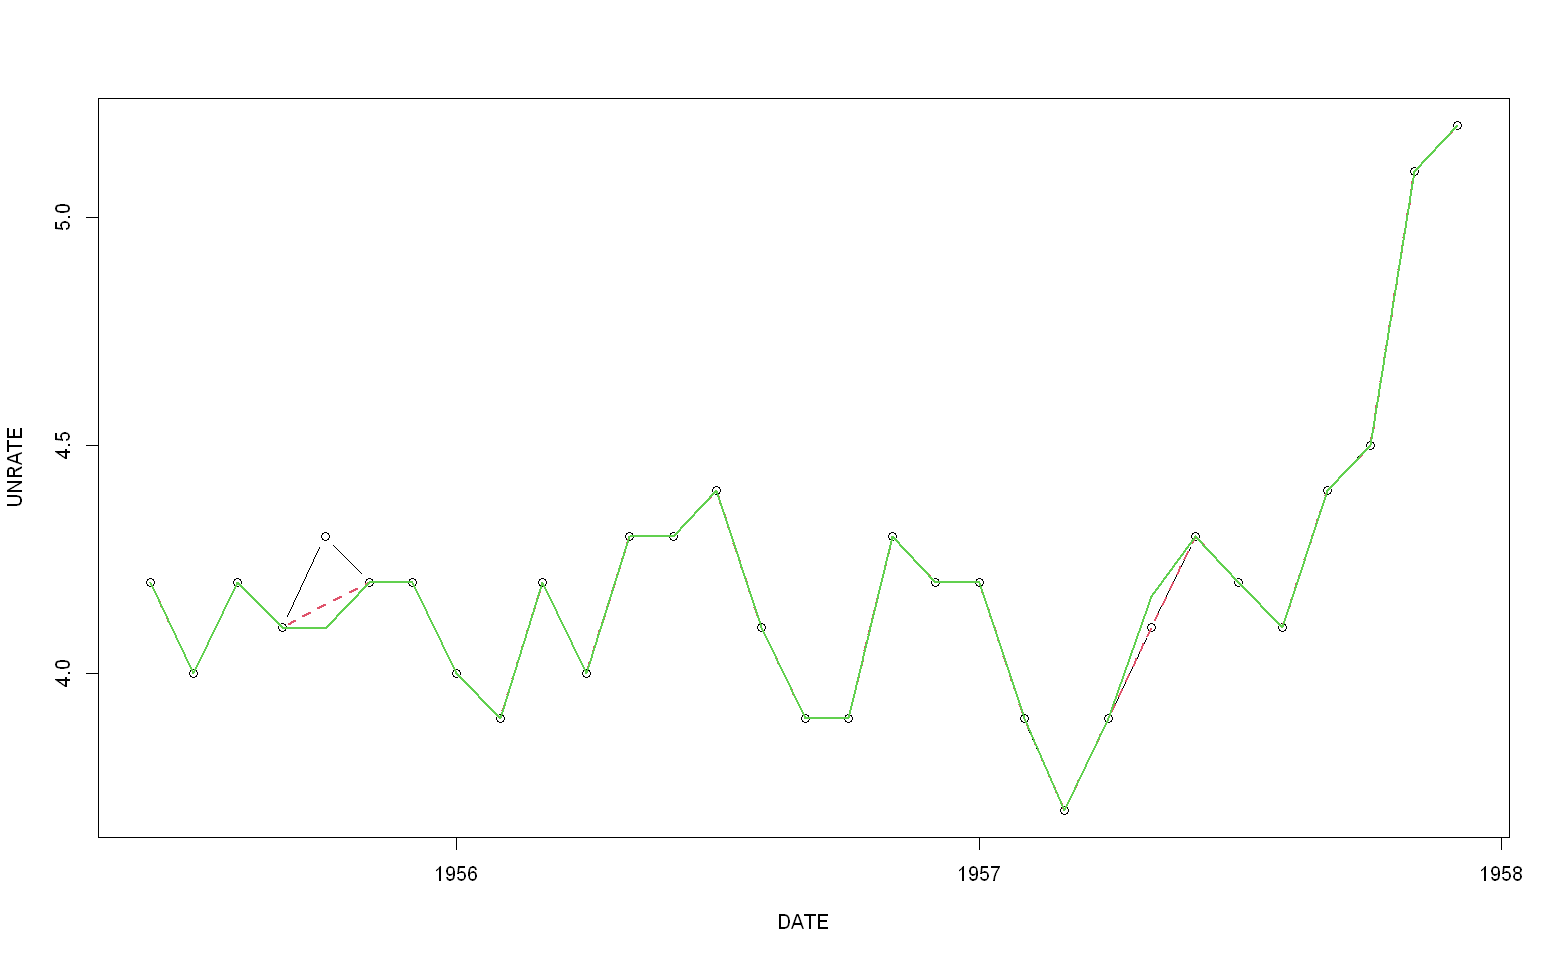

In [27]:
par(bg='white')
options(repr.plot.width = 13, repr.plot.height = 8)
unemp[use.idx, plot(
    DATE, UNRATE, col=1, type='b'
)]
rand.unemp[
    use.idx, lines(
    DATE, impute.li, col=2, lwd=2, lty=2
)
]
rand.unemp[use.idx, 
    lines(DATE, impute.sp, col=3, pch=19, cex=3, lwd=2)
]

In [28]:
# Calcular o erro médio quadrático para as colunas especificadas
errors <- rand.unemp[, lapply(.SD, function(x) mean((x - unemp$UNRATE)^2, na.rm = TRUE)), .SDcols = c("impute.ff", "impute.rm.naolookahead", "impute.li", "impute.sp")]

# Transformar a lista em vetor
errors_vector <- unlist(errors)

# Ordenar os erros
sorted_errors <- sort(errors_vector)
print(sorted_errors)


             impute.li              impute.sp              impute.ff 
           0.001836164            0.002514163            0.003459716 
impute.rm.naolookahead 
           0.004614929 


In [29]:
# Calcular o erro médio quadrático para as colunas especificadas
errors < bias.unemp[, lapply(.SD, function(x) mean((x - unemp$UNRATE)^2, na.rm = TRUE)), .SDcols = c("impute.ff", "impute.rm.naolookahead", "impute.li", "impute.sp")]

# Transformar a lista em vetor
errors_vector <- unlist(errors)

# Ordenar os erros
sorted_errors <- sort(errors_vector)
print(sorted_errors)


impute.ff,impute.rm.naolookahead,impute.li,impute.sp
FALSE,FALSE,FALSE,FALSE


             impute.li              impute.sp              impute.ff 
           0.001836164            0.002514163            0.003459716 
impute.rm.naolookahead 
           0.004614929 


### Downsampling

In [30]:
unemp[seq.int(from = 1, to=nrow(unemp), by=12)]

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1949-01-01,4.3
1950-01-01,6.5
1951-01-01,3.7
1952-01-01,3.2
1953-01-01,2.9
1954-01-01,4.9
1955-01-01,4.9
1956-01-01,4.0


In [31]:
unemp[, mean(UNRATE), by=format(DATE, "%Y")]

format,V1
<chr>,<dbl>
1948,3.750000
1949,6.050000
1950,5.208333
1951,3.283333
1952,3.025000
1953,2.925000
1954,5.591667
1955,4.366667
1956,4.125000


In [32]:
todas.data = seq(from = unemp$DATE[1], to=tail(unemp$DATE, 1), by='months')

In [33]:
todas.data

[1] "1948-01-01" "1948-02-01" "1948-03-01" "1948-04-01" "1948-05-01"
  [6] "1948-06-01" "1948-07-01" "1948-08-01" "1948-09-01" "1948-10-01"
 [11] "1948-11-01" "1948-12-01" "1949-01-01" "1949-02-01" "1949-03-01"
 [16] "1949-04-01" "1949-05-01" "1949-06-01" "1949-07-01" "1949-08-01"
 [21] "1949-09-01" "1949-10-01" "1949-11-01" "1949-12-01" "1950-01-01"
 [26] "1950-02-01" "1950-03-01" "1950-04-01" "1950-05-01" "1950-06-01"
 [31] "1950-07-01" "1950-08-01" "1950-09-01" "1950-10-01" "1950-11-01"
 [36] "1950-12-01" "1951-01-01" "1951-02-01" "1951-03-01" "1951-04-01"
 [41] "1951-05-01" "1951-06-01" "1951-07-01" "1951-08-01" "1951-09-01"
 [46] "1951-10-01" "1951-11-01" "1951-12-01" "1952-01-01" "1952-02-01"
 [51] "1952-03-01" "1952-04-01" "1952-05-01" "1952-06-01" "1952-07-01"
 [56] "1952-08-01" "1952-09-01" "1952-10-01" "1952-11-01" "1952-12-01"
 [61] "1953-01-01" "1953-02-01" "1953-03-01" "1953-04-01" "1953-05-01"
 [66] "1953-06-01" "1953-07-01" "1953-08-01" "1953-09-01" "1953-10-01"
 [71] "1953-11-01" "1953-12-01" "1954-01-01" "1954-02-01" "1954-03-01"
 [76] "1954-04-01" "1954-05-01" "1954-06-01" "1954-07-01" "1954-08-01"
 [81] "1954-09-01" "1954-10-01" "1954-11-01" "1954-12-01" "1955-01-01"
 [86] "1955-02-01" "1955-03-01" "1955-04-01" "1955-05-01" "1955-06-01"
 [91] "1955-07-01" "1955-08-01" "1955-09-01" "1955-10-01" "1955-11-01"
 [96] "1955-12-01" "1956-01-01" "1956-02-01" "1956-03-01" "1956-04-01"
[101] "1956-05-01" "1956-06-01" "1956-07-01" "1956-08-01" "1956-09-01"
[106] "1956-10-01" "1956-11-01" "1956-12-01" "1957-01-01" "1957-02-01"
[111] "1957-03-01" "1957-04-01" "1957-05-01" "1957-06-01" "1957-07-01"
[116] "1957-08-01" "1957-09-01" "1957-10-01" "1957-11-01" "1957-12-01"
[121] "1958-01-01" "1958-02-01" "1958-03-01" "1958-04-01" "1958-05-01"
[126] "1958-06-01" "1958-07-01" "1958-08-01" "1958-09-01" "1958-10-01"
[131] "1958-11-01" "1958-12-01" "1959-01-01" "1959-02-01" "1959-03-01"
[136] "1959-04-01" "1959-05-01" "1959-06-01" "1959-07-01" "1959-08-01"
[141] "1959-09-01" "1959-10-01" "1959-11-01" "1959-12-01" "1960-01-01"
[146] "1960-02-01" "1960-03-01" "1960-04-01" "1960-05-01" "1960-06-01"
[151] "1960-07-01" "1960-08-01" "1960-09-01" "1960-10-01" "1960-11-01"
[156] "1960-12-01" "1961-01-01" "1961-02-01" "1961-03-01" "1961-04-01"
[161] "1961-05-01" "1961-06-01" "1961-07-01" "1961-08-01" "1961-09-01"
[166] "1961-10-01" "1961-11-01" "1961-12-01" "1962-01-01" "1962-02-01"
[171] "1962-03-01" "1962-04-01" "1962-05-01" "1962-06-01" "1962-07-01"
[176] "1962-08-01" "1962-09-01" "1962-10-01" "1962-11-01" "1962-12-01"
[181] "1963-01-01" "1963-02-01" "1963-03-01" "1963-04-01" "1963-05-01"
[186] "1963-06-01" "1963-07-01" "1963-08-01" "1963-09-01" "1963-10-01"
[191] "1963-11-01" "1963-12-01" "1964-01-01" "1964-02-01" "1964-03-01"
[196] "1964-04-01" "1964-05-01" "1964-06-01" "1964-07-01" "1964-08-01"
[201] "1964-09-01" "1964-10-01" "1964-11-01" "1964-12-01" "1965-01-01"
[206] "1965-02-01" "1965-03-01" "1965-04-01" "1965-05-01" "1965-06-01"
[211] "1965-07-01" "1965-08-01" "1965-09-01" "1965-10-01" "1965-11-01"
[216] "1965-12-01" "1966-01-01" "1966-02-01" "1966-03-01" "1966-04-01"
[221] "1966-05-01" "1966-06-01" "1966-07-01" "1966-08-01" "1966-09-01"
[226] "1966-10-01" "1966-11-01" "1966-12-01" "1967-01-01" "1967-02-01"
[231] "1967-03-01" "1967-04-01" "1967-05-01" "1967-06-01" "1967-07-01"
[236] "1967-08-01" "1967-09-01" "1967-10-01" "1967-11-01" "1967-12-01"
[241] "1968-01-01" "1968-02-01" "1968-03-01" "1968-04-01" "1968-05-01"
[246] "1968-06-01" "1968-07-01" "1968-08-01" "1968-09-01" "1968-10-01"
[251] "1968-11-01" "1968-12-01" "1969-01-01" "1969-02-01" "1969-03-01"
[256] "1969-04-01" "1969-05-01" "1969-06-01" "1969-07-01" "1969-08-01"
[261] "1969-09-01" "1969-10-01" "1969-11-01" "1969-12-01" "1970-01-01"
[266] "1970-02-01" "1970-03-01" "1970-04-01" "1970-05-01" "1970-06-01"
[271] "1970-07-01" "1970-08-01" "1970-09-01" "1970-10-01" "1970-11-01"
[276] "1970-12-01" "1971-01-01" "1971-02-01" "1971-03-01" "1971-04-01"
[281] "1971-05-01" "1971-0

In [34]:
rand.unemp[J(todas.data) ,on='DATE' ,roll=0]

DATE,UNRATE,rpt,impute.ff,impute.rm.naolookahead,impute.li,impute.sp
<date>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
1948-01-01,3.4,FALSE,3.4,3.40,3.40,3.400000
1948-02-01,3.8,FALSE,3.8,3.80,3.80,3.800000
1948-03-01,4.0,FALSE,4.0,4.00,4.00,4.000000
1948-04-01,3.9,FALSE,3.9,3.90,3.90,3.900000
1948-05-01,NA,TRUE,3.9,3.95,3.75,3.738486
1948-06-01,3.6,FALSE,3.6,3.60,3.60,3.600000
1948-07-01,3.6,FALSE,3.6,3.60,3.60,3.600000
1948-08-01,3.9,FALSE,3.9,3.90,3.90,3.900000
1948-09-01,3.8,FALSE,3.8,3.80,3.80,3.800000
